# Práctica 4

## Importaciones

In [94]:
import pandas as pd
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from sklearn import manifold
from sklearn.discriminant_analysis import StandardScaler
import numpy as np
from scipy.spatial.distance import cdist
from umap import UMAP
from sklearn.manifold import Isomap

In [80]:
df = pd.read_excel("4000datosSimuladosEnergia.xlsx")

## PCA

In [81]:
X = df.drop(columns='Perfil de contrato')
y = df['Perfil de contrato']

In [82]:
X_scaled = StandardScaler().fit_transform(X)

Text(0.5, 1.0, 'PCA with two components')

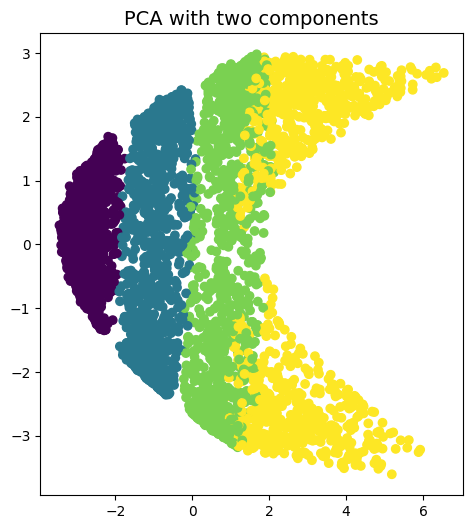

In [83]:
fig = plt.figure(figsize=(12,6))
k = 8
pca = PCA(n_components=2)
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)
ax = fig.add_subplot(1, 2, 1)
ax.scatter(X_pca[:, 0], X_pca[:, 1], c=y)
ax.set_title('PCA with two components', size=14)

## LLE

### Standard

In [84]:
n_neighbors = 100  # neighborhood which is used to recover the locally linear structure
n_components = 2  # number of coordinates for the manifold
params = {
    "n_neighbors": n_neighbors,
    "n_components": n_components,
    "eigen_solver": "auto",
    "random_state": 0,
}

Text(0.5, 1.0, 'LLE standard')

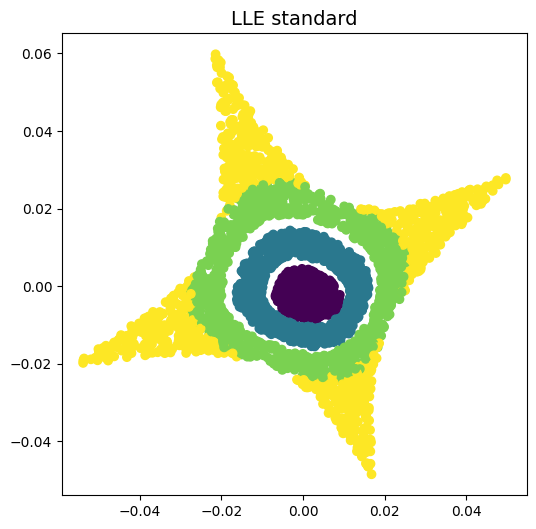

In [85]:
fig = plt.figure(figsize=(6,6))
model = manifold.LocallyLinearEmbedding(method="standard", **params)
X_lle = model.fit_transform(X_scaled)
ax = fig.add_subplot(1, 1, 1)
ax.scatter(X_lle[:, 0], X_lle[:, 1], c=y)
ax.set_title('LLE standard', size=14)

### LTSA

Text(0.5, 1.0, 'LLE ltsa')

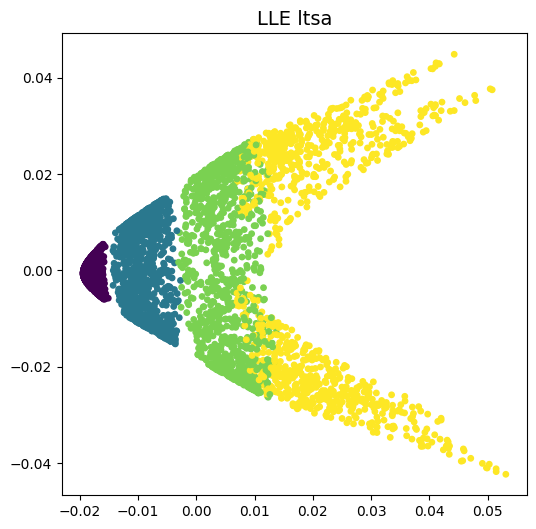

In [86]:
fig = plt.figure(figsize=(6,6))
model = manifold.LocallyLinearEmbedding(method="ltsa", **params)
X_ltsa = model.fit_transform(X_scaled)
ax = fig.add_subplot(1, 1, 1)
ax.scatter(X_ltsa[:, 0], X_ltsa[:, 1], c=y, s=15)
ax.set_title('LLE ltsa', size=14)

### MDS

Text(0.5, 1.0, 'MDS')

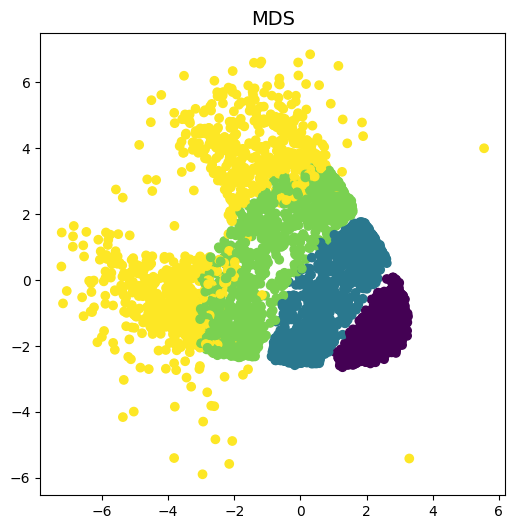

In [87]:
fig = plt.figure(figsize=(6,6))
model = manifold.MDS(
    n_components=n_components,
    max_iter=50,
    n_init=4,
    random_state=0,
    normalized_stress=False,
)
X_mds = model.fit_transform(X_scaled)
ax = fig.add_subplot(1, 1, 1)
ax.scatter(X_mds[:, 0], X_mds[:, 1], c=y)
ax.set_title('MDS', size=14)

In [88]:
class MDS:

    n_components = 2
    dissimilarity = "euclidean"
    embedding_ = None
    dissimilarity_matrix_ = None

    def __init__(self, n_components:int=2, dissimilarity="euclidean"):

        self.n_components = n_components
        if not dissimilarity in ["euclidean", "cosine", "precomputed"]:
            raise ValueError()
        self.dissimilarity = dissimilarity


    def fit(self, X:np.ndarray):
        
        n = X.shape[0]

        if self.dissimilarity == "euclidean":
            tmp = np.tile(X, (n, 1, 1))
            self.dissimilarity_matrix_ = np.sqrt(np.square(tmp - tmp.transpose((1, 0, 2))).sum(axis=2))
        elif self.dissimilarity == "cosine":
            tmp = np.dot(X, X.T)
            norm = np.sqrt(np.square(X).sum(axis=1))
            self.dissimilarity_matrix_ = 1 - tmp / norm / norm.reshape(-1, 1)
        else:
            self.dissimilarity_matrix_ = X
        
        h = np.eye(n) - np.ones((n, n)) / n
        k = -0.5 * np.dot(np.dot(h, self.dissimilarity_matrix_), h)
        evl, evc = np.linalg.eigh(k)
        evl_asort = evl.argsort()
        eids = evl_asort[::-1][:self.n_components]
        lamb = np.diag(evl[eids])
        v = evc[:, eids]
        self.embedding_ = np.dot(np.sqrt(lamb), v.T).T

    def fit_transform(self, X:np.ndarray):

        self.fit(X)
        return self.embedding_

Text(0.5, 1.0, 'MDS')

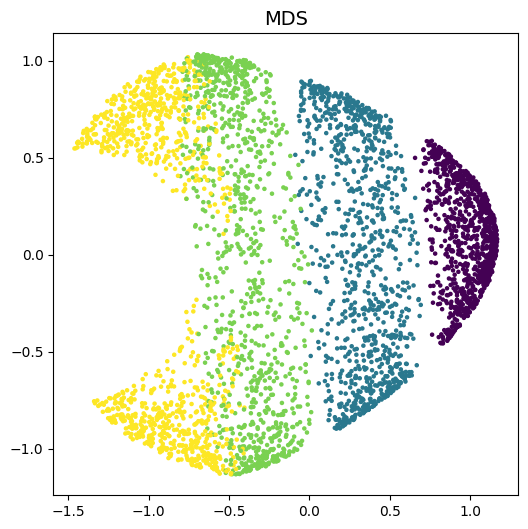

In [89]:
mds = MDS()
X_mds2 = mds.fit_transform(X_scaled)
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(X_mds2[:, 0], X_mds2[:, 1], c=y, s = 5)
ax.set_title('MDS', size=14)

## UMAP

Text(0.5, 1.0, 'UMAP')

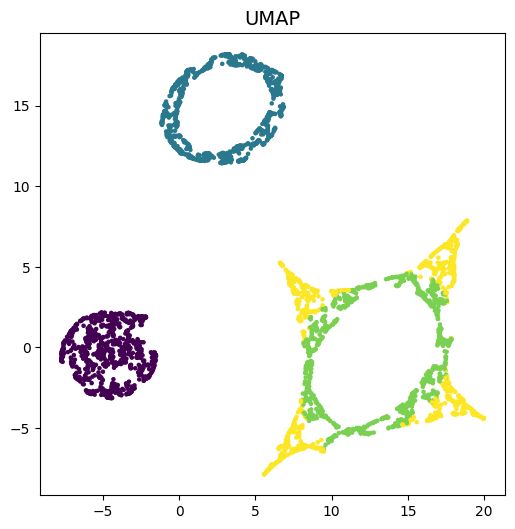

In [90]:
model = UMAP()
X_umap = model.fit_transform(X_scaled)
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(X_umap[:, 0], X_umap[:, 1], c=y, s = 5)
ax.set_title('UMAP', size=14)

## Sammon

In [91]:
def sammon(x, n, display = 1, inputdist = 'raw', maxhalves = 20, maxiter = 500, tolfun = 1e-9, init = 'default'):



    """Perform Sammon mapping on dataset x

    y = sammon(x) applies the Sammon nonlinear mapping procedure on
    multivariate data x, where each row represents a pattern and each column
    represents a feature.  On completion, y contains the corresponding
    co-ordinates of each point on the map.  By default, a two-dimensional
    map is created.  Note if x contains any duplicated rows, SAMMON will
    fail (ungracefully). 

    [y,E] = sammon(x) also returns the value of the cost function in E (i.e.
    the stress of the mapping).

    An N-dimensional output map is generated by y = sammon(x,n) .

    A set of optimisation options can be specified using optional
    arguments, y = sammon(x,n,[OPTS]):

       maxiter        - maximum number of iterations
       tolfun         - relative tolerance on objective function
       maxhalves      - maximum number of step halvings
       input          - {'raw','distance'} if set to 'distance', X is 
                        interpreted as a matrix of pairwise distances.
       display        - 0 to 2. 0 least verbose, 2 max verbose.
       init           - {'pca', 'cmdscale', random', 'default'}
                        default is 'pca' if input is 'raw', 
                        'msdcale' if input is 'distance'

    The default options are retrieved by calling sammon(x) with no
    parameters.

    File        : sammon.py
    Date        : 18 April 2014
    Authors     : Tom J. Pollard (tom.pollard.11@ucl.ac.uk)
                : Ported from MATLAB implementation by 
                  Gavin C. Cawley and Nicola L. C. Talbot

    Description : Simple python implementation of Sammon's non-linear
                  mapping algorithm [1].

    References  : [1] Sammon, John W. Jr., "A Nonlinear Mapping for Data
                  Structure Analysis", IEEE Transactions on Computers,
                  vol. C-18, no. 5, pp 401-409, May 1969.

    Copyright   : (c) Dr Gavin C. Cawley, November 2007.

    This program is free software; you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation; either version 2 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program; if not, write to the Free Software
    Foundation, Inc., 59 Temple Place, Suite 330, Boston, MA 02111-1307 USA

    """

    # Create distance matrix unless given by parameters
    if inputdist == 'distance':
        D = x
        if init == 'default':
            init = 'cmdscale'
    else:
        D = cdist(x, x)
        if init == 'default':
            init = 'pca'

    if inputdist == 'distance' and init == 'pca':
        raise ValueError("Cannot use init == 'pca' when inputdist == 'distance'")

    if np.count_nonzero(np.diagonal(D)) > 0:
        raise ValueError("The diagonal of the dissimilarity matrix must be zero")

    # Remaining initialisation
    N = x.shape[0]
    scale = 0.5 / D.sum()
    D = D + np.eye(N)     

    if np.count_nonzero(D<=0) > 0:
        raise ValueError("Off-diagonal dissimilarities must be strictly positive")   

    Dinv = 1 / D
    if init == 'pca':
        [UU,DD,_] = np.linalg.svd(x)
        y = UU[:,:n]*DD[:n] 
    elif init == 'cmdscale':
        y,e = cmdscale(D)
        y = y[:,:n]
    else:
        y = np.random.normal(0.0,1.0,[N,n])
    one = np.ones([N,n])
    d = cdist(y,y) + np.eye(N)
    dinv = 1. / d
    delta = D-d 
    E = ((delta**2)*Dinv).sum() 

    # Get on with it
    for i in range(maxiter):

        # Compute gradient, Hessian and search direction (note it is actually
        # 1/4 of the gradient and Hessian, but the step size is just the ratio
        # of the gradient and the diagonal of the Hessian so it doesn't
        # matter).
        delta = dinv - Dinv
        deltaone = np.dot(delta,one)
        g = np.dot(delta,y) - (y * deltaone)
        dinv3 = dinv ** 3
        y2 = y ** 2
        H = np.dot(dinv3,y2) - deltaone - np.dot(2,y) * np.dot(dinv3,y) + y2 * np.dot(dinv3,one)
        s = -g.flatten(order='F') / np.abs(H.flatten(order='F'))
        y_old    = y

        # Use step-halving procedure to ensure progress is made
        for j in range(maxhalves):
            s_reshape = np.reshape(s, (-1,n),order='F')
            y = y_old + s_reshape
            d = cdist(y, y) + np.eye(N)
            dinv = 1 / d
            delta = D - d
            E_new = ((delta**2)*Dinv).sum()
            if E_new < E:
                break
            else:
                s = 0.5*s

        # Bomb out if too many halving steps are required
        if j == maxhalves-1:
            print('Warning: maxhalves exceeded. Sammon mapping may not converge...')

        # Evaluate termination criterion
        if abs((E - E_new) / E) < tolfun:
            if display:
                print('TolFun exceeded: Optimisation terminated')
            break

        # Report progress
        E = E_new
        if display > 1:
            print('epoch = %d : E = %12.10f'% (i+1, E * scale))

    if i == maxiter-1:
        print('Warning: maxiter exceeded. Sammon mapping may not have converged...')

    # Fiddle stress to match the original Sammon paper
    E = E * scale
    
    return [y,E]

TolFun exceeded: Optimisation terminated


Text(0.5, 1.0, 'Sammon')

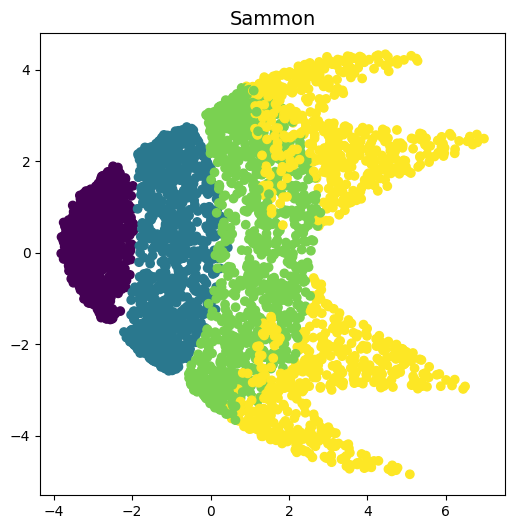

In [92]:
(sp,index) = np.unique(X_scaled,axis=0,return_index=True)
(X_sammon,y_sammon) = sammon(sp, 2)
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(X_sammon[:, 0], X_sammon[:, 1], c=y[index])
ax.set_title('Sammon', size=14)

## Isomap

Text(0.5, 1.0, 'Isomap with k = 100')

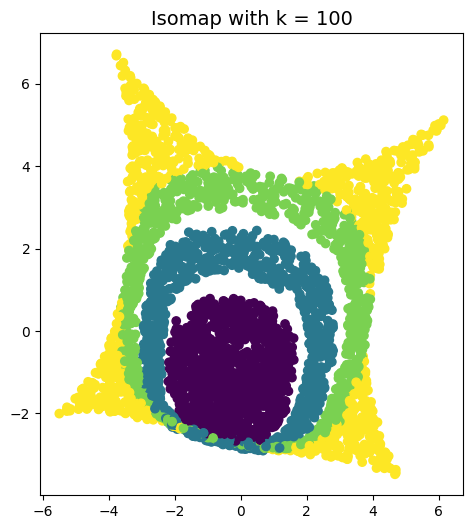

In [103]:
fig = plt.figure(figsize=(12,6))
k = 100
model = Isomap(n_components=2, n_neighbors=k)
X_iso = model.fit_transform(X_scaled)
ax = fig.add_subplot(1, 2, 2)
ax.scatter(X_iso[:, 0], X_iso[:, 1], c=y)
ax.set_title('Isomap with k = ' + str(k), size=14)

## t-SNE

Text(0.5, 1.0, 't-SNE with k = 100')

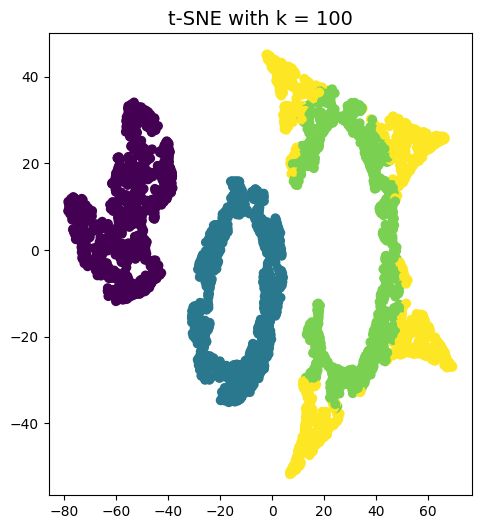

In [104]:
fig = plt.figure(figsize=(12,6))

model = manifold.TSNE(n_components=2, perplexity=40, random_state=0)
X_tsne = model.fit_transform(X_scaled)
ax = fig.add_subplot(1, 2, 2)
ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y)
ax.set_title('t-SNE with k = ' + str(k), size=14)